<a href="https://colab.research.google.com/github/Meridor6919/BeeClassification/blob/master/BeeClassification_RESNET_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import keras
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import datasets, layers, models, losses
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset , info = tfds.load('bee_dataset', split=['train'], as_supervised=True, with_info = True)

In [ ]:
#Split between training data, validation data, test data
splitSize = (0.0, 0.765, 0.9, 1.0)

In [ ]:
list(info.features["output"].keys())

['varroa_output', 'pollen_output', 'wasps_output', 'cooling_output']

In [ ]:
array = np.vstack(tfds.as_numpy(dataset[0]))
ranges = list([int(array.shape[0] * x) for x in splitSize])

def getDataset(ranges, idx):
    return (
        np.array(list(map(lambda x: x[0][:, :, :], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['varroa_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['pollen_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['wasps_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['cooling_output'], array[ranges[idx]: ranges[idx + 1]])))
    )
train_images, train_labels1,train_labels2,train_labels3, train_labels4= getDataset(ranges, 0)
validation_images, validation_labels1,validation_labels2, validation_labels3, validation_labels4 = getDataset(ranges, 1)
test_images, test_labels1,test_labels2,test_labels3, test_labels4  = getDataset(ranges, 2)

<ipython-input-71-e43ac078c997>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  array = np.vstack(tfds.as_numpy(dataset[0]))
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [ ]:
train_labels = np.dstack((train_labels1, train_labels2, train_labels3,train_labels4)).squeeze()
validation_labels = np.dstack((validation_labels1,validation_labels2, validation_labels3, validation_labels4)).squeeze()
test_labels = np.dstack((test_labels1,test_labels2,test_labels3, test_labels4)).squeeze()
train_labels.shape, train_labels[:10]

((5729, 4), array([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [ ]:
def identity_block(x, filter):
    x_skip = x
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter):
    x_skip = x
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:

def ResNet34(shape = (300,150, 3), classes =4):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.Rescaling(1./255)(x_input)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
def ResNet34(shape = (300,150, 3), classes =4):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.Rescaling(1./255)(x_input)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
model = ResNet34()

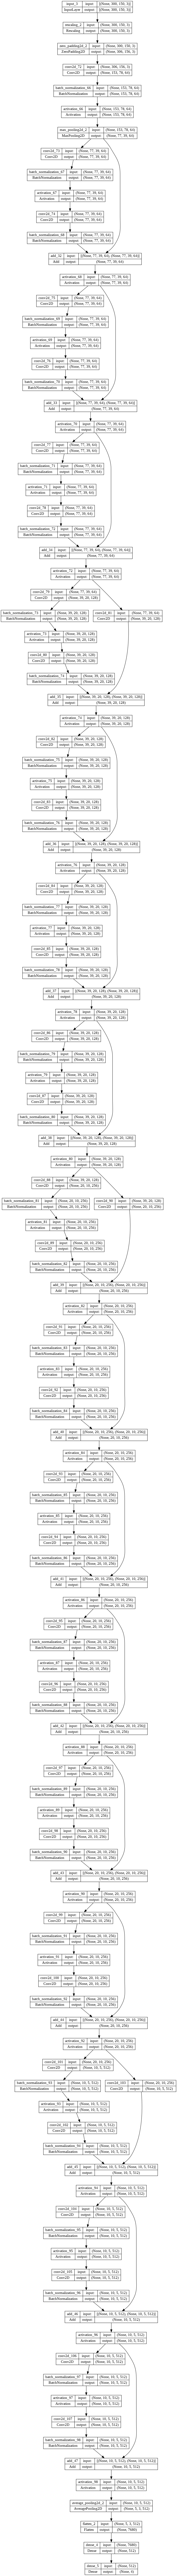

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


Softmax = Multi-Class Classification Problem = Only one right answer = Mutually exclusive outputs
$\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ $


Sigmoid = Multi-Label Classification Problem = More than one right answer = Non-exclusive outputs 
$\sigma(z) = \frac{1} {1 + e^{-z}}$

Accuracy = Multi-Class Classification Problem = Only one right answer:


In [ ]:
threshold= .7
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=tf.keras.metrics.BinaryAccuracy(threshold=threshold))

history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size = 32,
                    
                        validation_data=(validation_images, validation_labels))

Epoch 1/50
180/180 [==============================] - 40s 204ms/step - loss: 0.1757 - binary_accuracy: 0.9268 - val_loss: 4.3697 - val_binary_accuracy: 0.8550
Epoch 2/50
180/180 [==============================] - 36s 199ms/step - loss: 0.1369 - binary_accuracy: 0.9388 - val_loss: 0.3115 - val_binary_accuracy: 0.9069
Epoch 3/50
180/180 [==============================] - 36s 199ms/step - loss: 0.1370 - binary_accuracy: 0.9379 - val_loss: 0.7845 - val_binary_accuracy: 0.8718
Epoch 4/50
180/180 [==============================] - 36s 199ms/step - loss: 0.1350 - binary_accuracy: 0.9401 - val_loss: 0.1640 - val_binary_accuracy: 0.9338
Epoch 5/50
180/180 [==============================] - 36s 199ms/step - loss: 0.1417 - binary_accuracy: 0.9436 - val_loss: 1.9878 - val_binary_accuracy: 0.8352
Epoch 6/50
180/180 [==============================] - 36s 199ms/step - loss: 0.1045 - binary_accuracy: 0.9508 - val_loss: 0.2557 - val_binary_accuracy: 0.9103
Epoch 7/50
180/180 [==========================

In [ ]:
model.evaluate(test_images, test_labels)

24/24 [==============================] - 1s 58ms/step - loss: 0.1442 - binary_accuracy: 0.9773


[0.14420539140701294, 0.9773030877113342]

In [ ]:
def plot_loss(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['binary_accuracy']
  val_accuracy = history.history['val_binary_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

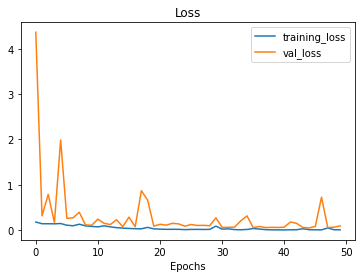

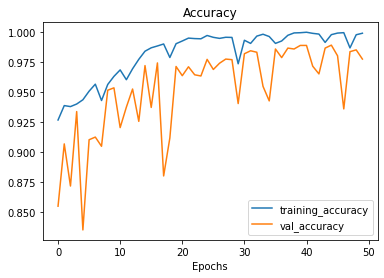

In [ ]:
plot_loss(history)

(<matplotlib.image.AxesImage at 0x7fe5e99dc970>, array([1., 0., 0., 0.]))

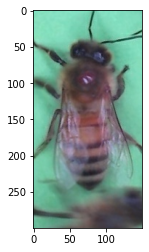

In [ ]:
x = test_images[55]
plt.imshow(x), test_labels[55]

In [ ]:
model.predict(x.reshape(1,300,150,3))

1/1 [==============================] - 0s 21ms/step


array([[1.0000000e+00, 2.0719495e-13, 2.7907843e-20, 6.3298128e-14]],
      dtype=float32)